# NDSI for Switzerland with Landsat 5,7,8 and Sentinel 2

In [1]:
import sys
sys.path.append("../")

In [2]:
## pour vider la poubelle du sdc
!rm -rf ~/.local/share/Trash/*

In [3]:
# Import dependencies

import os
import sys
import calendar
# import shutil
import gdal
import osr

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

#to create DEM classes
from xrspatial.classify import equal_interval
from datashader.transfer_functions import shade
from xrspatial.classify import reclassify

from datetime import datetime
# from multiprocessing import Pool, Lock, Manager
from matplotlib import colors
from IPython.display import display, Javascript
from time import time
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from collections import Counter
import pandas as pd #for data analysing

import datacube
dc = datacube.Datacube()

from utils.data_cube_utilities.dc_display_map import display_map
from swiss_utils.data_cube_utilities.sdc_utilities import draw_map
from swiss_utils.data_cube_utilities.sdc_utilities import create_slc_clean_mask, ls_qa_clean
from swiss_utils.data_cube_utilities.sdc_utilities import load_multi_clean_30, load_lss2_clean_30, mix_dataset


from utils.data_cube_utilities.dc_display_map import display_map, _degree_to_zoom_level
from utils.data_cube_utilities.dc_chunker import create_geographic_chunks, combine_geographic_chunks
from swiss_utils.data_cube_utilities.sdc_utilities import printandlog, load_multi_clean
from swiss_utils.data_cube_utilities.sdc_utilities import write_geotiff_from_xr

import warnings
warnings.filterwarnings("ignore")

Failed to resolve driver datacube.plugins.index::default
Error was: ContextualVersionConflict(click 8.0.4 (/home/localuser/Datacube/datacube_env/lib/python3.6/site-packages), Requirement.parse('click<8,>=4.0'), {'rasterio', 'cligj'})


In [4]:
# Configuration section

products = ["ls7_ledaps_swiss","ls5_ledaps_swiss",'ls8_lasrc_swiss', 's2_l2a_10m_swiss']
platforms = ["LANDSAT_7","LANDSAT_5",'LANDSAT_8','SENTINEL_2']

measurements=['green','swir1','pixel_qa','slc]


############### Switzerland all #############
min_lon =  5.7
max_lon =  10.55
min_lat = 45.74
max_lat = 47.85


#start_date = datetime.strptime("1984-11-30", '%Y-%m-%d')
#end_date = datetime.strptime("2000-01-01", '%Y-%m-%d')


start_year =1984
end_year = 2000

start_month = 12
end_month = 12

ind_season = ['DJF','DJF',
              'MAM','MAM','MAM',
              'JJA','JJA','JJA',
              'SON','SON','SON',
              'DJF']

resolution=(0.0003407435000010011,0.0003407435000010325)
resampling={'*': 'cubic', 'slc': 'nearest'}

work_path = './really_bigdata/Test_CP'
log_name = 'test_cp.log'
user_mail = 'cpoussin0@gmail.com'

In [5]:
display_map(latitude = (min_lat, max_lat), longitude = (min_lon, max_lon))

# Mask de la suisse

In [6]:
from osgeo import gdal
from PIL import Image


dataset = gdal.Open('Charlotte/Mask_Suisse/Mask_Suisse.tif')
print("Number of layers ".format(dataset.RasterCount))
print("==== Some info ====")
print("Size of tif file is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
print("Projection is {}".format(dataset.GetProjection()))
Mask_Suisse = np.array(dataset.GetRasterBand(1).ReadAsArray())
print("The shape of the array is {} ".format(Mask_Suisse.shape))

Number of layers 
==== Some info ====
Size of tif file is 14234 x 6194 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
The shape of the array is (6194, 14234) 


In [7]:
Mask_Suisse.resize(6195, 14234) # pour landsat seul
#Mask_Suisse.resize(6199, 14234) #pour landsat et sentinel ensemble

In [8]:
format(Mask_Suisse.shape)

'(6195, 14234)'

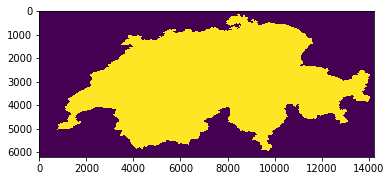

In [9]:
plt.imshow(Mask_Suisse)

## Mask lacs 
Attention pour les lacs c'est 0 et pas 1

In [10]:
from osgeo import gdal
from PIL import Image


dataset = gdal.Open('Charlotte/Mask_lacs/Mask_lacs.tif')
print("Number of layers ".format(dataset.RasterCount))
print("==== Some info ====")
print("Size of tif file is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
print("Projection is {}".format(dataset.GetProjection()))
Mask_lacs = np.array(dataset.GetRasterBand(1).ReadAsArray())
print("The shape of the array is {} ".format(Mask_lacs.shape))

Number of layers 
==== Some info ====
Size of tif file is 14234 x 6194 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
The shape of the array is (6194, 14234) 


In [11]:
Mask_lacs.resize(6195, 14234) #pour landsat seul
#Mask_lacs.resize(6199, 14234) #pour landsat et sentinel ensemble

In [12]:
format(Mask_lacs.shape)

'(6195, 14234)'

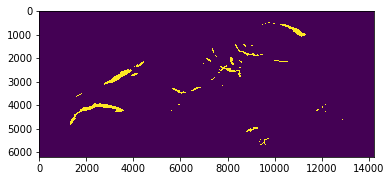

In [13]:
plt.imshow(Mask_lacs)

## Fonctions pour le mix Landsat-sentinel

In [ ]:
def get_platform(dc, products):
    """
    Description:
      Create a list of platforms from a list of products
    Input:
      dc:       datacube.api.core.Datacube
                The Datacube instance to load data with.
      products: list of products
    Output:
      list of platforms
    Authors:
      Bruno Chatenoux (UNEP/GRID-Geneva, 4.3.2019)
    """
    list_of_products = dc.list_products()
    platforms = []
    for product in products:
        try:
            platforms.append(list_of_products[list_of_products['name'] == product].iloc[0]['platform'])
        except:
            sys.exit('Cannot find a platform for product \"%s\"' % (prod))
    return platforms

In [ ]:
def load_multi_clean_30(dc, products, time, lon, lat, measurements,resolution, resampling, dropna = True, platforms = [], valid_cats = []):
    ##pour loader à 30 mèetre de résolution les donées sentinel-2 avec le masque
    """
    Description:
      Create a clean dataset (multi-product or not) using cleaning "autor's recommended ways"
      - ls_qa_clean
      - create_slc_clean_mask
      Sorted by ascending time
      Works with Landsat or Sentinel 2 (but not mixed).
      Platforms arguments are not mandatory
      dropna option removes time without any data
    Input:
      dc:           datacube.api.core.Datacube
                    The Datacube instance to load data with.
    Args:
      platforms:    list of platforms (not mandatory)
      products:     list of products
      time:         pair (list) of minimum and maximum date
      lon:          pair (list) of minimum and maximum longitude
      lat:          pair (list) of minimum and maximum longitude
      measurements: list of measurements (must include pixel_qa or slc (not and !))
      dropna:       if True removes times without any data
      valid_cats:   array of ints representing what category should be considered valid
                    * meand category by default
      # SENTINEL 2 ################################
      #   0 - no data                             #
      #   1 - saturated or defective              #
      #   2 - dark area pixels                    #
      #   3 - cloud_shadows                       #
      #   4 * vegetation                          #
      #   5 * not vegetated                       #
      #   6 * water                               #
      #   7 * unclassified                        #
      #   8 - cloud medium probability            #
      #   9 - cloud high probability              #
      #  10 - thin cirrus                         #
      #  11 * snow                                #
      #############################################
      # LANDSAT 5, 7 and 8 ########################
      #    0 : Fill                               #
      #    1 * Clear                              #
      #    2 * Water                              #
      #    3 : Cloud shadow                       #
      #    4 * Snow                               #
      #    5 : Cloud                              #
      #   10 : Terrain occlusion (Landsat 8 only) #
      #############################################
    Output:
      cleaned dataset and clean_mask sorted by ascending time
    Authors:
      Bruno Chatenoux (UNEP/GRID-Geneva, 10.12.2019)
    """

    # Check submitted input
    # Convert product string into list
    if isinstance(products, str):
        products = products.split()
    # Get platforms if not provided
    if len(products) != len(platforms):
        platforms = get_platform(dc, products)
    # Check LANDSAT and SENTINEL products are not mixed using products prefix
    prfx = []
    for platform in platforms:
        prfx. append(platform.split('_')[0])
    if len(set(prfx)) > 1:
        sys.exit('Mixed platforms %s' % (set(prfx)))

    # Create raw dataset
    dataset_clean = None
    for product,platform in zip(products, platforms):
        dataset_tmp = dc.load(platform = platform, product = product,
                         time = time,
                         lon = lon,
                         lat = lat,
                         resolution = resolution,
                         resampling = resampling,
                         measurements = measurements)

        if len(dataset_tmp.variables) == 0: continue # skip the current iteration if empty

        # Clean dataset_tmp
        if prfx[0] == "LANDSAT":
            if len(valid_cats) == 0: valid_cats = [1, 2, 4]
            clean_mask_tmp = ls_qa_clean(dataset_tmp.pixel_qa, valid_cats)
        elif platforms[0] == "SENTINEL_2":
            if len(valid_cats) == 0: valid_cats = [4, 5, 6, 7, 11]
            clean_mask_tmp = create_slc_clean_mask(dataset_tmp.slc, valid_cats)
        dataset_clean_tmp = dataset_tmp.where(clean_mask_tmp)
        del dataset_tmp

        # Remove negative values
        dataset_clean_tmp = dataset_clean_tmp.where(dataset_clean_tmp >= 0)
        
        if dataset_clean is None:
            dataset_clean = dataset_clean_tmp.copy(deep=True)
        else:
            dataset_clean = xr.concat([dataset_clean, dataset_clean_tmp], dim = 'time')
        del dataset_clean_tmp
    
    
    #if dropna:
        # remove time without any data
        #dataset_clean = dataset_clean.dropna('time', how='all')
    
    if dataset_clean is not None:
        # Sort dataset by ascending time
        dataset_clean = dataset_clean.sortby('time')
        return (dataset_clean, ~np.isnan(dataset_clean[measurements[0]].values))
    else:
        return (0, 0)

def tile_array(a, x0, x1, x2):
    t, r, c = a.shape                                    # number of rows/columns
    ts, rs, cs = a.strides                                # row/column strides 
    x = as_strided(a, (t, x0, r, x1, c, x2), (ts, 0, rs, 0, cs, 0)) # view a as larger 4D array
    return x.reshape(t*x0, r*x1, c*x2)    

In [ ]:
def load_lss2_clean_30(dc, products, time, lon, lat, measurements,
                    dropna = False, platforms = [], valid_cats = [[],[]]):
    ##pour loader dans un dictionnaire les données landsat et sentinel-2 à 30 mêtre de resolution 
    """
    Description:
      Create a clean dataset mixing Landsat and Sentinel 2 products (respectively with prefixs 'ls' and 's2')
      and using cleaning "autor's recommended ways":
      - ls_qa_clean
      - create_slc_clean_mask
      Sorted by ascending time
      If resample option is activated ('up' or 'down_mean', 'down_median') up/downsampling is performed and
      products output combined into a single 'lss2' prefix
      dropna option removes time without any data   
      This function works as load_multi_clean function, but with a mix of Landsat and Sentinel 2 products
      the resampl option was added (to optionally combine products output), and platforms options not used

    Input:
      dc:           datacube.api.core.Datacube
                    The Datacube instance to load data with.
    Args:
      products:     list of products
      time:         pair (list) of minimum and maximum date
      lon:          pair (list) of minimum and maximum longitude
      lat:          pair (list) of minimum and maximum longitude
      measurements: list of measurements (without mask band, landsat and Sentinel 2 products prefix shouls be
                    'ls or 's2)
      resampl:      (OPTIONAL) Up/Downsample ('up', 'down_mean', 'down_median' ) products and combine their
                    output
      dropna:       (OPTIONAL) if True removes times without any data
      platforms:    (OPTIONAL) list of platforms (not used but kept to better mimic load_multi_clean function)
      valid_cats:   (OPTIONAL) list of list of ints representing what category should be considered valid
                    first Landsat categories, then Sentinel 2 categories
                    * meand category by default
      # SENTINEL 2 ################################
      #   0 - no data                             #
      #   1 - saturated or defective              #
      #   2 - dark area pixels                    #
      #   3 - cloud_shadows                       #
      #   4 * vegetation                          #
      #   5 * not vegetated                       #
      #   6 * water                               #
      #   7 * unclassified                        #
      #   8 - cloud medium probability            #
      #   9 - cloud high probability              #
      #  10 - thin cirrus                         #
      #  11 * snow                                #
      #############################################
      # LANDSAT 5, 7 and 8 ########################
      #    0 : Fill                               #
      #    1 * Clear                              #
      #    2 * Water                              #
      #    3 : Cloud shadow                       #
      #    4 * Snow                               #
      #    5 : Cloud                              #
      #   10 : Terrain occlusion (Landsat 8 only) #
      #############################################
    Output:
      cleaned dataset and clean_mask sorted by ascending time stored in dictionnaries,
      if no up/downsampling is performed dictionnaries contains the two Landsat and Sentinel 2 output products
    Authors:
      Bruno Chatenoux (UNEP/GRID-Geneva, 11.12.2019)
    """
    
    # dictionnary sensor - mask band (Higher resolution first !)
    dict_sensmask = {'ls':'pixel_qa',
                     's2': 'slc'}
    
    resampl_opts = ['up']
    
    sensors = []
    for product in products:
        if product[:2] not in sensors:
            sensors.append(product[:2])
            
    # check sensors
    assert (sorted(set(sensors)) == sorted(set(dict_sensmask.keys()))), \
           '\nA mix of Landsat and Sentinel 2 products is required !\nYou should use load_multi_clean function'
    
    assert (len(valid_cats) == 2), \
           '\nvalid_cats argument must be a list of list (read the doc for more details)'
    
    dict_dsc = {}
    dict_cm = {}
    
    # Process first Landsat and then Sentinel 2 (based on dict_sensmask order)
    for index, sensor in enumerate(dict_sensmask.keys()):
        # Remove mask bands if any
        measurements = [ele for ele in measurements if ele not in dict_sensmask.values()]
        # append propermask band to measurements
        measurements.append(dict_sensmask[sensor])
        
        # fix Sentinel 2 geographical extent based on Landsat dataset
        if index == 1:
            resx = (dsc.longitude.values.max() - dsc.longitude.values.min()) / len(dsc.longitude.values)
            resy = (dsc.latitude.values.max() - dsc.latitude.values.min()) / len(dsc.latitude.values)
            lon = (dsc.longitude.values.min() - resx / 3, dsc.longitude.values.max() + resx / 3)
            lat = (dsc.latitude.values.min() - resy / 3, dsc.latitude.values.max() + resy / 3)
        
        dsc, cm = load_multi_clean_30(dc = dc,
                                  products = [prod for prod in products if prod[:2] == sensor] ,
                                  time = time,
                                  lon = lon,
                                  lat = lat,
                                  measurements = measurements,
                                  resolution = resolution,
                                  resampling = resampling,
                                  dropna = dropna,
                                  valid_cats = valid_cats[index])
        dict_dsc[sensor] = dsc
        dict_cm[sensor] = cm
    
    return dict_dsc, dict_cm

### cloud mask

In [14]:
#calculate NDSI                               
def NDSI(array):
    return (array.green - array.swir1)/(array.green + array.swir1)

In [15]:
# Create a dictionnary of pixel_qa bit categories
# Source: https://landsat.usgs.gov/landsat-surface-reflectance-quality-assessment

bit_cats = {"0":"Fill",
            "1":"Clear",
            "2":"Water",
            "3":"Cloud shadow",
            "4":"Snow",
            "5":"Cloud",
            "6":"Cloud Low confidence",
            "7":"Cloud Medium confidence",  # 6 and 7: "Cloud High confidence"
            "8":"Cirrus Low confidence",    # LANDSAT 8 ONLY FROM HERE AND BELOW
            "9":"Cirrus Medium confidence", # 8 and 9: "Cirrus High confidence"
            "10":"Terrain occlusion"
}

In [16]:
# Return bit length
# Source: https://www.quora.com/How-can-I-get-the-bit-length-of-a-number-in-python
def bit_length(int_type):
    length = 0
    while (int_type):
        int_type >>= 1
        length += 1
    return(length)

# Decode pixel_qa values
def decode_qa(qa, dic):
    cnt = 0
    cats = []
    for b in reversed(str(bin(qa))[2:]):
        if b == '1':
            # Create high conf category if bit 67 are 11
            if cnt == 7 and bit_cats['6'] in cats:
                cats.remove(dic[str(cnt - 1)])
                cats.append('Cloud High confidence')
            # Create high conf category if bit 89 are 11
            if cnt == 9 and bit_cats['8'] in cats:
                cats.remove(dic[str(cnt - 1)])
                cats.append('Cirrus High confidence')
            else:
                cats.append(dic[str(cnt)])
        cnt += 1
    return cats

# Print decoded pixel_qa values
def print_qas(qas):
    if len(qas) == 0:
        print("No element to decode")
    for v in sorted(qas):
        if v > 0:
            cats = decode_qa(v, bit_cats)
            print("%s: %s" % (v, ', '.join(cats)))
    return

# Return unique values and count
def unik_count(vals):
    bc = vals.flatten()
    bc = np.bincount(bc)
    unik = np.nonzero(bc)[0]
    cnt = bc[unik] * 100
    return (unik, cnt)

########################################
##Define the clean mask cat. for all Landsat
from functools import reduce  
import numpy as np  

def ls_qa_mask(ts, keys):
    if bit_len == 8:
        land_cover_endcoding = dict( fill          =  [1], 
                                     clear         =  [66,  130], 
                                     water         =  [68,  132],
                                     shadow        =  [72,  136],
                                     snow          =  [80,  112, 144, 176],
                                     cloud         =  [96, 160, 224],
                                     low_conf      =  [66,  68,  72, 96,],
                                     med_conf      =  [130, 132, 136, 160,],
                                     high_conf     =  [224],
                                     low_conf_cl   =  [322, 324, 328, 352, 834, 836,     840, 864],#pour na pas avoir de message d'erreur
                                   )
    if bit_len >= 9:
        land_cover_endcoding = dict( fill          =  [1] ,
                                     clear         =  [66,  130, 322, 386, 834, 898, 1346],
                                     water         =  [68,  132, 324, 388, 836, 900, 1348],
                                     shadow        =  [72,  136, 328, 392, 840, 904, 1350],
                                     snow          =  [80,  112, 144, 176, 336, 368, 400, 432, 848, 880, 812, 944, 1352],
                                     cloud         =  [96,  112, 160, 176, 224, 352, 368, 416, 432, 848, 880, 912, 944, 1352],
                                     low_conf      =  [66,  68,  72,  96,],
                                     med_conf      =  [130, 132, 136, 160],
                                     high_conf     =  [224],
                                     low_conf_cl   =  [322, 324, 328, 352, 834, 836, 840, 864],
                                     med_conf_cl   =  [386, 388, 392, 400, 416, 898, 900, 904, 928],
                                     high_conf_cl  =  [480, 992],
                                     low_conf_cir  =  [322, 324, 328, 336, 352, 368, 386, 388, 392, 400, 416, 432, 480],
                                     high_conf_cir =  [834, 836, 840, 848, 864, 898, 900, 904, 912, 92], 
                                     terrain_occ   =  [1346,1348, 1350, 1352]
                                   ) 
        
    def merge_lists(a, b): 
        return a.union(set(land_cover_endcoding[b]))
                        
    relevant_encodings = reduce(merge_lists, keys,set())
    return np.isin(ts.pixel_qa.values, list(relevant_encodings))
    
##

In [19]:
# Create a multi-sensor dataset
chunk_size = 3
global_time_start = datetime.now()
time_start = datetime.now()
print(time_start)

# Cut the geographic extents into chunks
geographic_chunks = create_geographic_chunks(latitude=(min_lat, max_lat), longitude=(min_lon, max_lon), geographic_chunk_size=chunk_size)

cnt = 0
chunks_nb = len(geographic_chunks)
product_chunks = []
# Loop through chunks
for index, chunk in enumerate(geographic_chunks):
    cnt += 1
    print('%s - %i/%i' % (datetime.now(), cnt, chunks_nb))
    


    create = True

    for i in range(len(platforms)):
        dataset_tmp = dc.load(platform = platforms[i],
            product= products[i],
            time=(start_date, end_date),
            lon=chunk['longitude'], 
            lat=chunk['latitude'],
            measurements=measurements)
    
        if len(dataset_tmp) > 0:
            if create:
                dataset_in = dataset_tmp.copy(deep=True)
                create = False
            else:
                print("Append %i time\n" % (len(dataset_tmp.time)))
                dataset_in = xr.concat([dataset_in, dataset_tmp], dim = 'time')

    # Keep selected months
    dataset_in = dataset_in.sel(time=np.isin(dataset_in['time.month'], sel_months))
   
    # Cloud mask
    dc_qas, dc_cnt = unik_count(dataset_in.pixel_qa.values)
    #print_qas(dc_qas)

    bit_len = bit_length(max(dc_qas))
    
    ##Apply the mask in our dataset considering what we want
    cl_mask = ls_qa_mask(dataset_in, ["clear","water","snow"])
    ts_clean = dataset_in.where(cl_mask)
    
    #### NDSI ###
    ndsi = NDSI(ts_clean)
    #add variable NDSI in the dataset
    ts_clean['ndsi']=ndsi
    
    ###Apply the region mask
    ## To apply the mask in the dataset
    #ts_clean_GranP = ts_clean.where((Mask_GranP ==1))
    
    ##### Max NDSI ######
    #before to resample we have to sort time because of the multiplatform
    #ndsi_sorted=ndsi.reindex(time=sorted(ndsi.time.values))
    # resample by month instead of groupby
    max_ndsi = ndsi.resample(time='1D', skipna=True).max('time')
    # Remove empty dataset created by resample
    max_ndsi = max_ndsi.dropna('time', how='all')
    #create a dataset with the variable max_ndsi_month
    dataset_clean_CH = max_ndsi.to_dataset(name='max_ndsi')

    product_chunks.append(dataset_clean_CH)
    
# Combine chunks 
with np.errstate(divide='ignore'):
    ts = combine_geographic_chunks(product_chunks)
    
del product_chunks
del dataset_tmp
del dataset_in

print('Done in %s' % (datetime.now()-time_start))

2024-04-15 15:35:19.169976
2024-04-15 15:35:19.170828 - 1/4
2024-04-15 15:35:50.579557 - 2/4
2024-04-15 15:36:52.860660 - 3/4
2024-04-15 15:38:01.240640 - 4/4
Done in 0:03:28.359582


In [20]:
NDSI = ts.where((Mask_lacs ==0))
#NDSI = ts.where((Mask_Suisse ==1))

In [22]:
NDSI = NDSI.where((Mask_Suisse ==1))

In [28]:
write_geotiff_from_xr('really_bigdata/NDSI_l7_06.tif', NDSI.isel(time=5), list(NDSI.data_vars), compr='')

# MAX, min, mean NDSI by month

In [33]:

def multi_ndsi(i):
    dataset_clean, clean_mask = load_multi_clean(dc = dc, products = products , time = [start_date, end_date],
                                                      lon = geographic_chunks[i]['longitude'],
                                                      lat = geographic_chunks[i]['latitude'],
                                                      measurements = measurements)
    if dataset_clean != 0:
        ndsi = (dataset_clean.green - dataset_clean.swir1) / (dataset_clean.green + dataset_clean.swir1)

        ndsi_count = ndsi.count(dim=['time'])
        ndsi_qual = np.rint((ndsi_count / len(ndsi['time']) * 100)).astype(np.uint8)
        del dataset_clean
        del clean_mask
        #max
        ndsi_max = ndsi.max(dim = ['time'])
        ndsi_max.name = 'ndsi_max'
        #min
        ndsi_min = ndsi.min(dim = ['time'])
        ndsi_min.name = 'ndsi_min'        
        #mean
        ndsi_mean = ndsi.mean(dim = ['time'])
        ndsi_mean.name = 'ndsi_mean'        

        # Append result
        ndsi_max_chunks.append(ndsi_max.to_dataset(name='max'))
        del ndsi_max
        ndsi_min_chunks.append(ndsi_min.to_dataset(name='min'))
        del ndsi_min
        ndsi_mean_chunks.append(ndsi_mean.to_dataset(name='mean'))
        del ndsi_mean
        
        ndsi_count_chunks.append(ndsi_count.to_dataset(name='count'))
        del ndsi_count
        ndsi_qual_chunks.append(ndsi_qual.to_dataset(name='qual'))
        del ndsi_qual
      
        
    else:
        print("N/A")

In [ ]:

def multi_ndsi(i):
    dataset_clean, clean_mask = load_multi_clean(dc = dc, products = products , time = [start_date, end_date],
                                                      lon = geographic_chunks[i]['longitude'],
                                                      lat = geographic_chunks[i]['latitude'],
                                                      measurements = measurements)
    if dataset_clean != 0:
        swir1 = dataset_clean.swir1
        nir = dataset_clean.nir
        red = dataset_clean.red

        ndsi_count = swir1.count(dim=['time'])
        ndsi_qual = np.rint((ndsi_count / len(swir1['time']) * 100)).astype(np.uint8)
        del dataset_clean
        del clean_mask
        #max
        swir1_max = swir1.max(dim = ['time'])
        swir1_max.name = 'swir1'
        #max
        nir_max = nir.max(dim = ['time'])
        nir_max.name = 'nir'        
        #mean
        red_max = red.max(dim = ['time'])
        red_max.name = 'red'        

        # Append result
        swir1_max_chunks.append(swir1_max.to_dataset(name='max'))
        del swir1_max
        nir_max_chunks.append(nir_max.to_dataset(name='min'))
        del nir_max
        red_max_chunks.append(red_max.to_dataset(name='mean'))
        del red_max
      
        
    else:
        print("N/A")

In [34]:
%%time

# Create/Empty working directory
if not os.path.exists(work_path):
    os.makedirs(work_path)

# Cut the geographic extents into chunks
chunk_size = 0.5
geographic_chunks = create_geographic_chunks(latitude=(min_lat, max_lat),
                                             longitude=(min_lon, max_lon),
                                             geographic_chunk_size=chunk_size)
tot = len(geographic_chunks)

printandlog('NDSI max, min, mean by month calculation started')
start_time = datetime.now()
years = range(start_year, end_year + 1)
months = range(start_month, end_month + 1)

for year in years:
    for month in months:
        starty_time = datetime.now()
        print('Processing %i/%i' % (month, year))

        start_date = datetime.strptime("%i-%i-1" % (year, month), '%Y-%m-%d')
        # Need to find last days of a given month
        end_date = datetime.strptime("%i-%i-%i" % (year, month, calendar.monthrange(year, month)[1]), '%Y-%m-%d')

        ndsi_max_chunks = []
        ndsi_min_chunks = []
        ndsi_mean_chunks = []
        ndsi_count_chunks = []
        ndsi_qual_chunks = []

        bar_len = 20
        
        for i in range(tot): 
            multi_ndsi(i)
            filled_len = round(bar_len * (i + 1) /  tot)
            #\r commande à Python de revenir à la ligne où {0} et {1} sont des indices 
            sys.stdout.write('\r[{0}{1}] in {2}'
                         .format('#' * filled_len, '-' * (bar_len - filled_len), datetime.now() - starty_time))
        sys.stdout.write('\r[{0}] in {1} - COMPLETED\n'.format('#' * bar_len, datetime.now() - starty_time))
        
        if len (ndsi_max_chunks) > 0:
            # Combine chunks
            with np.errstate(divide='ignore'):
                NDSI = combine_geographic_chunks(ndsi_max_chunks)
                NDSI = NDSI.merge(combine_geographic_chunks(ndsi_min_chunks))
                NDSI = NDSI.merge(combine_geographic_chunks(ndsi_mean_chunks)) 
                NDSI = NDSI.merge(combine_geographic_chunks(ndsi_count_chunks))
                NDSI = NDSI.merge(combine_geographic_chunks(ndsi_qual_chunks))

            del ndsi_max_chunks
            del ndsi_min_chunks
            del ndsi_mean_chunks
            del ndsi_count_chunks
            del ndsi_qual_chunks
            
            NDSI = NDSI.where((Mask_lacs ==0))
            NDSI = NDSI.where((Mask_Suisse ==1))

            write_geotiff_from_xr('%s/NDSI_%s_%02d_l7.tif'% (work_path, year, month), NDSI, list(NDSI.data_vars), compr='')

            
printandlog('NDSI monthly raw data calculated', log_name, started = start_time)
            
            
printandlog('ALL DONE\n', log_name)

2024-04-15 14:44:39.759999 | NDSI max, min, mean by month calculation started
Processing 12/2000
[####################] in 0:04:14.387555 - COMPLETED
2024-04-15 14:49:11.435789 | NDSI monthly raw data calculated (done in 0:04:31.675169)
2024-04-15 14:49:11.437465 | ALL DONE

CPU times: user 3min 36s, sys: 1min 14s, total: 4min 51s
Wall time: 4min 31s


## MAX, mean, min NDSI by month mix landsat-Sentinel 

In [ ]:
def multi_ndsi(i):
    dict_dsc, dict_cm = load_lss2_clean_30(dc = dc,
                                    products = products ,
                                    time = [start_date, end_date],
                                    lon = geographic_chunks[i]['longitude'],
                                    lat = geographic_chunks[i]['latitude'],
                                    measurements = measurements,
                                    #resampl = 'up',
                                    #dropna = True ,
                                    valid_cats = [[1,2,4],[4,5,6,7,11]])
    
    dict_dsc['ls']['mask'] = dict_dsc['ls']['pixel_qa']
    dict_dsc['ls'] = dict_dsc['ls'].drop(['pixel_qa'])
    
    dict_dsc['s2']['mask'] = dict_dsc['s2']['slc']
    dict_dsc['s2'] = dict_dsc['s2'].drop(['slc']) 
    
    da = xr.concat((dict_dsc['ls'],dict_dsc['s2']), data_vars=dict_dsc['s2'].data_vars , dim='time')
    
    ds = da.sortby('time')    
    
    if ds != 0:
        ndsi = (ds.green - ds.swir1) / (ds.green + ds.swir1)

        ndsi_count = ndsi.count(dim=['time'])
        ndsi_qual = np.rint((ndsi_count / len(ndsi['time']) * 100)).astype(np.uint8)
        del dict_dsc
        del dict_cm
        #max
        ndsi_max = ndsi.max(dim = ['time'])
        ndsi_max.name = 'ndsi_max'
        #min
        ndsi_min = ndsi.min(dim = ['time'])
        ndsi_min.name = 'ndsi_min'        
        #mean
        ndsi_mean = ndsi.mean(dim = ['time'])
        ndsi_mean.name = 'ndsi_mean'        

        # Append result
        ndsi_max_chunks.append(ndsi_max.to_dataset(name='max'))
        del ndsi_max
        ndsi_min_chunks.append(ndsi_min.to_dataset(name='min'))
        del ndsi_min
        ndsi_mean_chunks.append(ndsi_mean.to_dataset(name='mean'))
        del ndsi_mean
        
        ndsi_count_chunks.append(ndsi_count.to_dataset(name='count'))
        del ndsi_count
        ndsi_qual_chunks.append(ndsi_qual.to_dataset(name='qual'))
        del ndsi_qual
      
        
    else:
        print("N/A")

In [ ]:
def multi_ndsi(i):
    dict_dsc, dict_cm = load_lss2_clean_30(dc = dc,
                                    products = products ,
                                    time = [start_date, end_date],
                                    lon = geographic_chunks[i]['longitude'],
                                    lat = geographic_chunks[i]['latitude'],
                                    measurements = measurements,
                                    #resampl = 'up',
                                    #dropna = True ,
                                    valid_cats = [[1,2,4],[4,5,6,7,11]])
    
    dict_dsc['ls']['mask'] = dict_dsc['ls']['pixel_qa']
    dict_dsc['ls'] = dict_dsc['ls'].drop(['pixel_qa'])
    
    dict_dsc['s2']['mask'] = dict_dsc['s2']['slc']
    dict_dsc['s2'] = dict_dsc['s2'].drop(['slc']) 
    
    da = xr.concat((dict_dsc['ls'],dict_dsc['s2']), data_vars=dict_dsc['s2'].data_vars , dim='time')
    
    ds = da.sortby('time')    
    
    if ds != 0:
        swir1 = ds.swir1
        nir = ds.nir
        red = ds.red

        ndsi_count = swir1.count(dim=['time'])
        ndsi_qual = np.rint((ndsi_count / len(swir1['time']) * 100)).astype(np.uint8)
        del dict_dsc
        del dict_cm
        #max
        swir1_max = swir1.max(dim = ['time'])
        swir1_max.name = 'swir1'
        #max
        nir_max = nir.max(dim = ['time'])
        nir_max.name = 'nir'        
        #mean
        red_max = red.max(dim = ['time'])
        red_max.name = 'red'        

        # Append result
        swir1_max_chunks.append(swir1_max.to_dataset(name='max'))
        del swir1_max
        nir_max_chunks.append(nir_max.to_dataset(name='min'))
        del nir_max
        red_max_chunks.append(red_max.to_dataset(name='mean'))
        del red_max
      
        
    else:
        print("N/A")

In [ ]:
%%time

# Create/Empty working directory
if not os.path.exists(work_path):
    os.makedirs(work_path)

# Cut the geographic extents into chunks
chunk_size = 0.5
geographic_chunks = create_geographic_chunks(latitude=(min_lat, max_lat),
                                             longitude=(min_lon, max_lon),
                                             geographic_chunk_size=chunk_size)
tot = len(geographic_chunks)

printandlog('NDSI max, min, mean by month calculation started')
start_time = datetime.now()
years = range(start_year, end_year + 1)
months = range(start_month, end_month + 1)

for year in years:
    for month in months:
        starty_time = datetime.now()
        print('Processing %i/%i' % (month, year))

        start_date = datetime.strptime("%i-%i-1" % (year, month), '%Y-%m-%d')
        # Need to find last days of a given month
        end_date = datetime.strptime("%i-%i-%i" % (year, month, calendar.monthrange(year, month)[1]), '%Y-%m-%d')

        ndsi_max_chunks = []
        ndsi_min_chunks = []
        ndsi_mean_chunks = []
        ndsi_count_chunks = []
        ndsi_qual_chunks = []

        bar_len = 20
        
        for i in range(tot): 
            multi_ndsi(i)
            filled_len = round(bar_len * (i + 1) /  tot)
            #\r commande à Python de revenir à la ligne où {0} et {1} sont des indices 
            sys.stdout.write('\r[{0}{1}] in {2}'
                         .format('#' * filled_len, '-' * (bar_len - filled_len), datetime.now() - starty_time))
        sys.stdout.write('\r[{0}] in {1} - COMPLETED\n'.format('#' * bar_len, datetime.now() - starty_time))
        
        if len (ndsi_max_chunks) > 0:
            # Combine chunks
            with np.errstate(divide='ignore'):
                NDSI = combine_geographic_chunks(ndsi_max_chunks)
                NDSI = NDSI.merge(combine_geographic_chunks(ndsi_min_chunks))
                NDSI = NDSI.merge(combine_geographic_chunks(ndsi_mean_chunks)) 
                NDSI = NDSI.merge(combine_geographic_chunks(ndsi_count_chunks))
                NDSI = NDSI.merge(combine_geographic_chunks(ndsi_qual_chunks))

            del ndsi_max_chunks
            del ndsi_min_chunks
            del ndsi_mean_chunks
            del ndsi_count_chunks
            del ndsi_qual_chunks
            
            #NDSI = NDSI.where((Mask_lacs ==0))
            #NDSI = NDSI.where((Mask_Suisse ==1))

            write_geotiff_from_xr('%s/NDSI_%s_%02d.tif'% (work_path, year, month), NDSI, list(NDSI.data_vars), compr='')

            
printandlog('NDSI monthly raw data calculated', log_name, started = start_time)
            
            
printandlog('ALL DONE\n', log_name)

In [ ]:
%%time

# Create/Empty working directory
if not os.path.exists(work_path):
    os.makedirs(work_path)

# Cut the geographic extents into chunks
chunk_size = 0.5
geographic_chunks = create_geographic_chunks(latitude=(min_lat, max_lat),
                                             longitude=(min_lon, max_lon),
                                             geographic_chunk_size=chunk_size)
tot = len(geographic_chunks)

printandlog('NDSI max, min, mean by month calculation started')
start_time = datetime.now()
years = range(start_year, end_year + 1)
months = range(start_month, end_month + 1)

for year in years:
    for month in months:
        starty_time = datetime.now()
        print('Processing %i/%i' % (month, year))

        start_date = datetime.strptime("%i-%i-1" % (year, month), '%Y-%m-%d')
        # Need to find last days of a given month
        end_date = datetime.strptime("%i-%i-%i" % (year, month, calendar.monthrange(year, month)[1]), '%Y-%m-%d')

        swir1_max_chunks = []
        nir_max_chunks = []
        red_max_chunks = []


        bar_len = 20
        
        for i in range(tot): 
            multi_ndsi(i)
            filled_len = round(bar_len * (i + 1) /  tot)
            #\r commande à Python de revenir à la ligne où {0} et {1} sont des indices 
            sys.stdout.write('\r[{0}{1}] in {2}'
                         .format('#' * filled_len, '-' * (bar_len - filled_len), datetime.now() - starty_time))
        sys.stdout.write('\r[{0}] in {1} - COMPLETED\n'.format('#' * bar_len, datetime.now() - starty_time))
        
        if len (swir1_max_chunks) > 0:
            # Combine chunks
            with np.errstate(divide='ignore'):
                NDSI = combine_geographic_chunks(swir1_max_chunks)
                NDSI = NDSI.merge(combine_geographic_chunks(nir_max_chunks)) 
                NDSI = NDSI.merge(combine_geographic_chunks(red_max_chunks))

            del swir1_max_chunks
            del nir_max_chunks
            del red_max_chunks

            
            #NDSI = NDSI.where((Mask_lacs ==0))
            #NDSI = NDSI.where((Mask_Suisse ==1))

            write_geotiff_from_xr('%s/NDSI_%s_%02d.tif'% (work_path, year, month), NDSI, list(NDSI.data_vars), compr='')

            
printandlog('NDSI monthly raw data calculated', log_name, started = start_time)
            
            
printandlog('ALL DONE\n', log_name)

## Max min mean by month with only sentinel-2 at 30m 

In [ ]:
def multi_ndsi(i):
    dataset_clean, clean_mask = load_multi_clean_30(dc = dc, products = products , time = [start_date, end_date],
                                                      lon = geographic_chunks[i]['longitude'],
                                                      lat = geographic_chunks[i]['latitude'],
                                                      valid_cats = [4,5,6,7,11],
                                                    measurements= measurements,
                                                   resolution =(0.0003407435000010011,0.0003407435000010325),
                                                   resampling ={'*': 'cubic', 'slc': 'nearest'})
    if dataset_clean != 0:
        ndsi = (dataset_clean.green - dataset_clean.swir1) / (dataset_clean.green + dataset_clean.swir1)

        ndsi_count = ndsi.count(dim=['time'])
        ndsi_qual = np.rint((ndsi_count / len(ndsi['time']) * 100)).astype(np.uint8)
        del dataset_clean
        del clean_mask
        #max
        ndsi_max = ndsi.max(dim = ['time'])
        ndsi_max.name = 'ndsi_max'
        #min
        ndsi_min = ndsi.min(dim = ['time'])
        ndsi_min.name = 'ndsi_min'        
        #mean
        ndsi_mean = ndsi.mean(dim = ['time'])
        ndsi_mean.name = 'ndsi_mean'        

        # Append result
        ndsi_max_chunks.append(ndsi_max.to_dataset(name='max'))
        del ndsi_max
        ndsi_min_chunks.append(ndsi_min.to_dataset(name='min'))
        del ndsi_min
        ndsi_mean_chunks.append(ndsi_mean.to_dataset(name='mean'))
        del ndsi_mean
        
        ndsi_count_chunks.append(ndsi_count.to_dataset(name='count'))
        del ndsi_count
        ndsi_qual_chunks.append(ndsi_qual.to_dataset(name='qual'))
        del ndsi_qual
      
        
    else:
        print("N/A")

In [ ]:
%%time

# Create/Empty working directory
if not os.path.exists(work_path):
    os.makedirs(work_path)

# Cut the geographic extents into chunks
chunk_size = 0.5
geographic_chunks = create_geographic_chunks(latitude=(min_lat, max_lat),
                                             longitude=(min_lon, max_lon),
                                             geographic_chunk_size=chunk_size)
tot = len(geographic_chunks)

printandlog('NDSI max, min, mean by month calculation started')
start_time = datetime.now()
years = range(start_year, end_year + 1)
months = range(start_month, end_month + 1)

for year in years:
    for month in months:
        starty_time = datetime.now()
        print('Processing %i/%i' % (month, year))

        start_date = datetime.strptime("%i-%i-1" % (year, month), '%Y-%m-%d')
        # Need to find last days of a given month
        end_date = datetime.strptime("%i-%i-%i" % (year, month, calendar.monthrange(year, month)[1]), '%Y-%m-%d')

        ndsi_max_chunks = []
        ndsi_min_chunks = []
        ndsi_mean_chunks = []
        ndsi_count_chunks = []
        ndsi_qual_chunks = []

        bar_len = 20
        
        for i in range(tot): 
            multi_ndsi(i)
            filled_len = round(bar_len * (i + 1) /  tot)
            #\r commande à Python de revenir à la ligne où {0} et {1} sont des indices 
            sys.stdout.write('\r[{0}{1}] in {2}'
                         .format('#' * filled_len, '-' * (bar_len - filled_len), datetime.now() - starty_time))
        sys.stdout.write('\r[{0}] in {1} - COMPLETED\n'.format('#' * bar_len, datetime.now() - starty_time))
        
        if len (ndsi_max_chunks) > 0:
            # Combine chunks
            with np.errstate(divide='ignore'):
                NDSI = combine_geographic_chunks(ndsi_max_chunks)
                NDSI = NDSI.merge(combine_geographic_chunks(ndsi_min_chunks))
                NDSI = NDSI.merge(combine_geographic_chunks(ndsi_mean_chunks)) 
                NDSI = NDSI.merge(combine_geographic_chunks(ndsi_count_chunks))
                NDSI = NDSI.merge(combine_geographic_chunks(ndsi_qual_chunks))

            del ndsi_max_chunks
            del ndsi_min_chunks
            del ndsi_mean_chunks
            del ndsi_count_chunks
            del ndsi_qual_chunks
            
            #NDSI = NDSI.where((Mask_lacs ==0))
            #NDSI = NDSI.where((Mask_Suisse ==1))

            write_geotiff_from_xr('%s/NDSI_%s_%02d.tif'% (work_path, year, month), NDSI, list(NDSI.data_vars), compr='')

            
printandlog('NDSI monthly raw data calculated', log_name, started = start_time)
            
            
printandlog('ALL DONE\n', log_name)

## MAX NDSI by month with a thr of 0.4

In [ ]:
ndsi_threshold = 0.4
def multi_ndsi(i):
    dataset_clean, clean_mask = load_multi_clean(dc = dc, products = products , time = [start_date, end_date],
                                                      lon = geographic_chunks[i]['longitude'],
                                                      lat = geographic_chunks[i]['latitude'],
                                                      measurements = measurements)
    if dataset_clean != 0:
        ndsi = (dataset_clean.green - dataset_clean.swir1) / (dataset_clean.green + dataset_clean.swir1)

        ndsi_count = ndsi.count(dim=['time'])
        ndsi_qual = np.rint((ndsi_count / len(ndsi['time']) * 100)).astype(np.uint8)
        del dataset_clean
        del clean_mask
        ndsi_max = ndsi.max(dim = ['time'])
        ndsi_max.name = 'ndsi_max'
        #for a threshold of 0.4
        #Here we want to keep nan as nan, 0 for NDSi < 0.4 and 1 for NDSI > 0.4
        #This step is important for the time series analyses, we have to distinguish nan to 0 
        ndsi_thr = ndsi_max > ndsi_threshold
        ndsi_thr.astype(int)
        #
        ndsi_thr1 = ndsi_thr * ndsi_max
        ndsi_thr2 = ndsi_thr1.notnull()
        positive = ndsi_thr1 > 0
        ndsi_thr3 = positive.fillna(0.).where(ndsi_thr2)
        ndsi_thr3

        # Append result
        ndsi_max_chunks.append(ndsi_max.to_dataset(name='max'))
        del ndsi_max
        ndsi_count_chunks.append(ndsi_count.to_dataset(name='count'))
        del ndsi_count
        ndsi_qual_chunks.append(ndsi_qual.to_dataset(name='qual'))
        del ndsi_qual
        ndsi_thr_chunks.append(ndsi_thr3.to_dataset(name="snow"))
        del ndsi_thr
        del ndsi_thr1
        del ndsi_thr2
        del ndsi_thr3
        
        
    else:
        print("N/A")

In [ ]:
# Create/Empty working directory
if not os.path.exists(work_path):
    os.makedirs(work_path)

# Cut the geographic extents into chunks
chunk_size = 0.5
geographic_chunks = create_geographic_chunks(latitude=(min_lat, max_lat),
                                             longitude=(min_lon, max_lon),
                                             geographic_chunk_size=chunk_size)
tot = len(geographic_chunks)

print('NDSI max by month calculation started')
start_time = datetime.now()
years = range(start_year, end_year + 1)
months = range(start_month, end_month + 1)

for year in years:
    for month in months:
        starty_time = datetime.now()
        print('Processing %i/%i' % (month, year))

        start_date = datetime.strptime("%i-%i-1" % (year, month), '%Y-%m-%d')
        # Need to find last days of a given month
        end_date = datetime.strptime("%i-%i-%i" % (year, month, calendar.monthrange(year, month)[1]), '%Y-%m-%d')

        ndsi_max_chunks = []
        ndsi_count_chunks = []
        ndsi_qual_chunks = []
        ndsi_thr_chunks = []

        bar_len = 20
        
#         for i, _ in enumerate(p.imap(multi_ndvi, range(tot))):
#             filled_len = round(bar_len * (i + 1) / tot)
#             sys.stdout.write('\r[{0}{1}] in {2}'
#                              .format('#' * filled_len, '-' * (bar_len - filled_len), datetime.now() - starty_time))
#         sys.stdout.write('\r[{0}] in {1} - COMPLETED\n'.format('#' * bar_len, datetime.now() - starty_time))
#         p.close()
        
        for i in range(tot): 
            multi_ndsi(i)
            filled_len = round(bar_len * (i + 1) /  tot)
            #\r commande à Python de revenir à la ligne où {0} et {1} sont des indices 
            sys.stdout.write('\r[{0}{1}] in {2}'
                         .format('#' * filled_len, '-' * (bar_len - filled_len), datetime.now() - starty_time))
            sys.stdout.write('\r[{0}] in {1} - COMPLETED\n'.format('#' * bar_len, datetime.now() - starty_time))
        
        if len (ndsi_max_chunks) > 0:
            # Combine chunks
            with np.errstate(divide='ignore'):
                NDSI = combine_geographic_chunks(ndsi_max_chunks)    
                #NDSI = NDSI.merge(combine_geographic_chunks(ndsi_count_chunks))
                #NDSI = NDSI.merge(combine_geographic_chunks(ndsi_qual_chunks))
                NDSI = NDSI.merge(combine_geographic_chunks(ndsi_thr_chunks))
            del ndsi_max_chunks
            del ndsi_count_chunks
            del ndsi_qual_chunks
            del ndsi_thr_chunks
            NDSI.to_netcdf('%s/NDSI_%s_%02d.nc' % (work_path, year, month))

            
printandlog('NDSI monthly max calculated', log_name, started = start_time)
            
            
printandlog('ALL DONE\n', log_name)


## MAX, min, mean NDSI by year

In [ ]:
def multi_ndsi(i):
    dict_dsc, dict_cm = load_lss2_clean_30(dc = dc,
                                    products = products ,
                                    time = [start_date, end_date],
                                    lon = geographic_chunks[i]['longitude'],
                                    lat = geographic_chunks[i]['latitude'],
                                    measurements = measurements,
                                    #resampl = 'up',
                                    #dropna = True ,
                                    valid_cats = [[1,2,4],[4,5,6,7,11]])
    
    dict_dsc['ls']['mask'] = dict_dsc['ls']['pixel_qa']
    dict_dsc['ls'] = dict_dsc['ls'].drop(['pixel_qa'])
    
    dict_dsc['s2']['mask'] = dict_dsc['s2']['slc']
    dict_dsc['s2'] = dict_dsc['s2'].drop(['slc']) 
    
    da = xr.concat((dict_dsc['ls'],dict_dsc['s2']), data_vars=dict_dsc['s2'].data_vars , dim='time')
    
    ds = da.sortby('time')   
    
    if ds != 0:
        ndsi = (ds.green - ds.swir1) / (ds.green + ds.swir1)

        #ndsi_count = ndsi.count(dim=['time'])
        #ndsi_qual = np.rint((ndsi_count / len(ndsi['time']) * 100)).astype(np.uint8)
        del dict_dsc
        del dict_cm
        #max
        #ndsi_max = ndsi.max(dim = ['time'])
        #ndsi_max.name = 'ndsi_max'
        #min
        #ndsi_min = ndsi.min(dim = ['time'])
        #ndsi_min.name = 'ndsi_min'        
        #mean
        ndsi_mean = ndsi.mean(dim = ['time'])
        ndsi_mean.name = 'ndsi_mean'        

        # Append result
        #ndsi_max_chunks.append(ndsi_max.to_dataset(name='max'))
        #del ndsi_max
        #ndsi_min_chunks.append(ndsi_min.to_dataset(name='min'))
        #del ndsi_min
        ndsi_mean_chunks.append(ndsi_mean.to_dataset(name='mean'))
        del ndsi_mean
        
        #ndsi_count_chunks.append(ndsi_count.to_dataset(name='count'))
        #del ndsi_count
        #ndsi_qual_chunks.append(ndsi_qual.to_dataset(name='qual'))
        #del ndsi_qual
      
        
    else:
        print("N/A")

In [ ]:
%%time

# Create working directory if necessary
if not os.path.exists(work_path):
    os.makedirs(work_path)

# Cut the geographic extents into chunks
chunk_size = 0.1
geographic_chunks = create_geographic_chunks(latitude=(min_lat, max_lat),
                                             longitude=(min_lon, max_lon),
                                             geographic_chunk_size=chunk_size)
tot = len(geographic_chunks)

printandlog('NDWI annual mean calculation started', log_name, reset = True)
start_time = datetime.now()
years = range(start_year, end_year + 1)

for year_ind, year in enumerate(years):
    starty_time = datetime.now()
    printandlog('Processing year %i' % year, log_name)

    start_date = datetime.strptime("%i-%i-1" % (year, start_month), '%Y-%m-%d')
    # Need to find last days of a given month
    end_date = datetime.strptime("%i-%i-%i" % (year, end_month, calendar.monthrange(year, end_month)[1]), '%Y-%m-%d')
    
    #ndsi_max_chunks = []
    #ndsi_min_chunks = []
    ndsi_mean_chunks = []
    #ndsi_count_chunks = []
    #ndsi_qual_chunks = []
    
    bar_len = 20

    for i in range(tot): 
        multi_ndsi(i)
        filled_len = round(bar_len * (i + 1) /  tot)
        #\r commande à Python de revenir à la ligne où {0} et {1} sont des indices 
        sys.stdout.write('\r[{0}{1}] in {2}'
                         .format('#' * filled_len, '-' * (bar_len - filled_len), datetime.now() - starty_time))
    sys.stdout.write('\r[{0}] in {1} - COMPLETED\n'.format('#' * bar_len, datetime.now() - starty_time))
        
    if len (ndsi_mean_chunks) > 0:
        # Combine chunks
        with np.errstate(divide='ignore'):
            NDSI = combine_geographic_chunks(ndsi_mean_chunks)
            #NDSI = NDSI.merge(combine_geographic_chunks(ndsi_min_chunks))
            #NDSI = NDSI.merge(combine_geographic_chunks(ndsi_mean_chunks)) 
            #NDSI = NDSI.merge(combine_geographic_chunks(ndsi_count_chunks))
            #NDSI = NDSI.merge(combine_geographic_chunks(ndsi_qual_chunks))

        #del ndsi_max_chunks
        #del ndsi_min_chunks
        del ndsi_mean_chunks
        #del ndsi_count_chunks
        #del ndsi_qual_chunks
            
        #NDSI = NDSI.where((Mask_lacs ==0))
        #NDSI = NDSI.where((Mask_Suisse ==1))

        write_geotiff_from_xr('%s/NDSI_%s_v4.tif'% (work_path, year), NDSI, list(NDSI.data_vars), compr='')

            
printandlog('NDSI annual raw data calculated', log_name, started = start_time)
            
            
printandlog('ALL DONE\n', log_name)

In [ ]:
NDSI

In [ ]:
format(Mask_lacs.shape)

In [ ]:
NDSI = NDSI.where((Mask_lacs ==0))
NDSI = NDSI.where((Mask_Suisse ==1))